## Imports

In [31]:
import os
import jax
import numpyro
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import hssm
import arviz as az
import seaborn as sns

jax.config.update('jax_platform_name', 'cpu')
hssm.set_floatX("float32")
numpyro.set_host_device_count(14)

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [2]:
df_raw = pd.read_csv('data_wt_exp5.csv')

## Definitions

In [3]:
def subsitute_values_sequential(data,varname,new_values):
  unique_values = sorted(data[varname].unique())
  substitutions = {val: new_val for val, new_val in zip(unique_values,new_values)}
  return  data[varname].replace(substitutions)

In [4]:
def robust_z(x):
    x = np.asarray(x, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 0.6745 * (x - med) / (mad if mad>0 else np.finfo(float).eps)

### Data Cleanup

In [5]:
data = df_raw.copy()

## stim side l/r (-1/1)
data['stim_side'] =  np.sign(data['stim'])

## Desirability side l/r (-1/1)
data['des_side'] = np.sign(data['stim'])*data['desirability']

## Stim evidence: low vs high (0/1)
data['stim_easy'] = subsitute_values_sequential(data,'stim_strength',[0.25,.5,0.75,1])

## Incentive: low vs high (0/1)
data['incentive'] = subsitute_values_sequential(data,'incentive',[-.5,.5])

## direction and magnitude
data['stim_des'] = data['stim_easy']*data['desirability'] 

data['resp_des'] = data['resp']*data['des_side'] #responded desirable vs undesirable (+1/-1)

data = data[data['desirability']!=0] #keep only trials with desirability manipulation (for now)
#%% Data cleaning/exclusion

MIN_RT = 200 
MAX_RT = 35000 
MAD_THRESH_RT = 3

ACC_THRESH_LO = 0.525 
ACC_THRESH_HI = 0.975

MIN_TRIALS_PER_COND = 8
COND_VARS = ['incentive', 'desirability']

#count original number of trials before exclusion
n_trials_raw= len(data)

In [6]:
data = data[(~data['correct'].isna()) & (~data['rt'].isna())
             & (data['rt']> MIN_RT) & (data['rt'] < MAX_RT) & (~data['resp'].isna())]

In [7]:
data = data[data.groupby('participant')['rt'].transform(lambda x: abs(robust_z(x)))<MAD_THRESH_RT]


In [8]:
print('N trials excluded = %i / %i'%(n_trials_raw - len(data),n_trials_raw))

print('Mean RT = %i ms, median RT = %i ms, max RT = %i ms' % (data['rt'].mean(),data['rt'].median(),data['rt'].max()))

N trials excluded = 1066 / 19200
Mean RT = 1734 ms, median RT = 1502 ms, max RT = 29557 ms


## Participant Cleanup

In [9]:
participant_accuracy = data.groupby('participant')['correct'].mean()
valid_participants = participant_accuracy[(participant_accuracy > ACC_THRESH_LO) & (participant_accuracy < ACC_THRESH_HI)].index

print('N participants kept (accuracy) = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

#remove participants with extreme median RTs compared to sample
participant_rt = data.groupby('participant')['rt'].median()
valid_participants_rt = participant_rt[np.abs(robust_z(participant_rt))<3].index
print('N participants kept (RT) = %i / %i'%(len(valid_participants_rt),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants_rt)]

# remove participants, who, after exclsion, have too few trials for one or more conditions
groupby_vars = ['participant']
groupby_vars.extend(COND_VARS)
sub_trials_per_cond = data.groupby(groupby_vars).size().reset_index(name='n_trials')

#get list of participants that have at least min_trials_per_cond trials per condition (combination of incentive and desirability values)
df_participants_with_min_trials = sub_trials_per_cond.groupby('participant').filter(lambda x: (x['n_trials'] >= MIN_TRIALS_PER_COND).all())
valid_participants = df_participants_with_min_trials['participant'].unique().tolist()
print('N participants kept after excluding participants with too few trials = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

N participants kept (accuracy) = 438 / 600
N participants kept (RT) = 427 / 438
N participants kept after excluding participants with too few trials = 425 / 427


## HSSM DataFrame

In [10]:
df_hssm = pd.DataFrame({
    'response': data['resp_des'].astype('int32'),
    'rt': (data['rt'] / 1000).astype('float32'),
    'participant_id': data['participant'].astype('int32')
})

df_hssm = df_hssm.astype({col: 'float32' for col in df_hssm.select_dtypes(include='float64').columns})

In [11]:
df_hssm

,response,rt,participant_id
0,-1,1.115,1
1,-1,2.170,1
2,-1,2.096,1
3,1,1.687,1
4,1,2.857,1
...,...,...,...
19195,-1,2.616,600
19196,1,2.698,600
19197,1,1.673,600
19198,1,1.415,600


In [12]:
random_ids = np.random.choice(
    df_hssm.participant_id.unique(),
    size=round(len(df_hssm.participant_id.unique())/10),
    replace = False
)

In [13]:
df_test = df_hssm[df_hssm['participant_id'].isin(random_ids)]

In [14]:
df_test

,response,rt,participant_id
32,1,1.1693,2
33,-1,1.1226,2
34,1,0.9846,2
35,1,1.5569,2
36,1,1.5088,2
...,...,...,...
19066,-1,0.7335,596
19067,1,1.2877,596
19069,-1,0.7442,596
19070,-1,1.6148,596


## Fit model

In [15]:
'''
param_names = ['v_Intercept', 'a_Intercept', 't_Intercept', 'z_Intercept']
posterior_samples = {param: [] for param in param_names}
ess_bulk = {param: [] for param in param_names}
ess_tail = {param: [] for param in param_names}
r_hat = {param: [] for param in param_names}
'''


"\nparam_names = ['v_Intercept', 'a_Intercept', 't_Intercept', 'z_Intercept']\nposterior_samples = {param: [] for param in param_names}\ness_bulk = {param: [] for param in param_names}\ness_tail = {param: [] for param in param_names}\nr_hat = {param: [] for param in param_names}\n"

In [16]:
results = []

In [18]:
for nsub, isub in enumerate(df_hssm['participant_id'].unique()):
    print(f"___Participant {isub}, {nsub+1}/{len(df_hssm['participant_id'].unique())}___")

    participant_folder = f"plots/Exp4/S{int(isub):04d}"   
    os.makedirs(participant_folder, exist_ok=True)

    df_hssm = df_test

    df_sub = df_hssm[df_hssm['participant_id'] == isub]
    df_sub.drop('participant_id', axis = 1, inplace=True)

    print("Median RT =", np.median(df_sub['rt']))
    print("N trials =", len(df_sub))

    model = hssm.HSSM(
        model="ddm",
        data=df_sub,
        include=[
            {
                "name":"v",
                "formula":"v ~ 1",
                "prior":{"Intercept":{"name":"Normal","mu":0,"sigma":1}}
            },
        ]
    )

    infer_data_sub = model.sample(
        cores=3,
        chains=3,
        draws=300,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
        progressbar=True,
        target_accept=0.99,
    )

    fit_dict = infer_data_sub.to_dict()

    summary_table = az.summary(infer_data_sub)
    print(summary_table.to_string())
    with open(os.path.join(participant_folder, "summary_table.txt"), "w") as file:
        file.write(summary_table.to_string())

        # Save plots
    az.plot_posterior(infer_data_sub)
    plt.savefig(os.path.join(participant_folder, "posterior_plot.png"))
    plt.close()

___Participant 2, 1/42___
Median RT = 1.27795
N trials = 32


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.736  0.282   0.205    1.243      0.014    0.010     410.0     523.0   1.00
z            0.528  0.074   0.400    0.676      0.004    0.003     394.0     438.0   1.00
a            0.939  0.097   0.746    1.092      0.005    0.004     339.0     427.0   1.00
t            0.728  0.057   0.625    0.816      0.004    0.003     290.0     296.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 20, 2/42___
Median RT = 1.1363
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -1.911  0.548  -2.922   -0.939      0.037    0.028     233.0     350.0   1.01
z            0.495  0.132   0.177    0.692      0.008    0.006     283.0     256.0   1.01
a            1.566  0.811   0.724    3.151      0.070    0.050     140.0     289.0   1.02
t            0.463  0.126   0.211    0.693      0.010    0.007     201.0     123.0   1.02


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 56, 3/42___
Median RT = 1.601
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.156  0.218  -0.246    0.564      0.010    0.008     458.0     434.0   1.01
z            0.444  0.066   0.330    0.574      0.003    0.002     501.0     503.0   1.00
a            0.995  0.091   0.839    1.173      0.005    0.004     393.0     458.0   1.01
t            0.670  0.061   0.557    0.792      0.004    0.002     333.0     314.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 58, 4/42___
Median RT = 1.746
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.378  0.251  -0.855    0.081      0.013    0.009     393.0     441.0   1.01
z            0.563  0.067   0.440    0.693      0.004    0.003     285.0     406.0   1.02
a            0.918  0.089   0.763    1.079      0.004    0.003     395.0     495.0   1.01
t            1.070  0.063   0.934    1.192      0.004    0.003     273.0     245.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 62, 5/42___
Median RT = 1.1875
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 52 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.213  0.275  -0.216    0.799      0.017    0.012     265.0     295.0   1.02
z            0.388  0.063   0.271    0.503      0.004    0.003     239.0     301.0   1.02
a            0.912  0.095   0.752    1.099      0.009    0.006     117.0     145.0   1.02
t            0.641  0.081   0.517    0.773      0.015    0.011      36.0     209.0   1.06
___Participant 81, 6/42___
Median RT = 1.753
N trials = 27


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.074  0.222  -0.343    0.514      0.013    0.011     318.0     160.0   1.01
z            0.492  0.079   0.363    0.650      0.005    0.003     322.0     215.0   1.01
a            1.203  0.115   0.976    1.412      0.006    0.004     412.0     235.0   1.01
t            0.415  0.104   0.224    0.628      0.005    0.004     399.0     208.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 83, 7/42___
Median RT = 2.2426
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.737  0.254   0.303    1.215      0.014    0.010     357.0     448.0   1.01
z            0.578  0.087   0.423    0.732      0.005    0.004     263.0     314.0   1.01
a            1.484  0.290   1.099    1.871      0.021    0.015     193.0     314.0   1.02
t            1.164  0.137   0.905    1.347      0.011    0.007     196.0     223.0   1.04


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 90, 8/42___
Median RT = 1.2844
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.286  0.252  -0.189    0.743      0.013    0.009     405.0     463.0   1.01
z            0.391  0.064   0.260    0.500      0.003    0.002     388.0     488.0   1.01
a            0.924  0.082   0.773    1.077      0.004    0.003     493.0     529.0   1.01
t            0.523  0.045   0.435    0.592      0.003    0.002     351.0     273.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 105, 9/42___
Median RT = 2.6754498
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.641  0.239  -1.106   -0.210      0.019    0.013     165.0     174.0   1.02
z            0.608  0.083   0.440    0.746      0.011    0.008      95.0      47.0   1.04
a            1.156  0.113   0.953    1.369      0.006    0.004     442.0     376.0   1.01
t            1.575  0.092   1.394    1.783      0.013    0.010      69.0      38.0   1.05


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 114, 10/42___
Median RT = 2.379
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.062  0.217  -0.427    0.348      0.010    0.007     418.0     550.0   1.01
z            0.488  0.064   0.355    0.599      0.003    0.002     415.0     542.0   1.01
a            1.124  0.112   0.930    1.327      0.005    0.004     476.0     474.0   1.00
t            1.368  0.093   1.209    1.514      0.006    0.004     330.0     306.0   1.00


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 118, 11/42___
Median RT = 1.43875
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.409  0.285  -0.919    0.126      0.012    0.009     516.0     563.0   1.01
z            0.507  0.069   0.391    0.643      0.003    0.002     487.0     422.0   1.01
a            0.846  0.078   0.711    0.996      0.004    0.003     478.0     509.0   1.00
t            0.821  0.043   0.744    0.896      0.002    0.002     410.0     352.0   1.00


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 125, 12/42___
Median RT = 1.2915
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.216  0.300  -0.309    0.774      0.020    0.014     234.0     299.0   1.01
z            0.581  0.070   0.441    0.708      0.005    0.004     171.0     332.0   1.02
a            0.878  0.088   0.705    1.031      0.005    0.003     326.0     358.0   1.00
t            0.672  0.053   0.588    0.799      0.006    0.004     109.0     163.0   1.03


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 138, 13/42___
Median RT = 1.3951
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.021  0.349  -0.667    0.661      0.019    0.013     337.0     466.0   1.01
z            0.507  0.069   0.377    0.627      0.004    0.003     344.0     414.0   1.00
a            0.729  0.073   0.607    0.867      0.003    0.002     509.0     419.0   1.00
t            0.954  0.035   0.880    1.006      0.002    0.001     413.0     321.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 149, 14/42___
Median RT = 0.86
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.745  0.378   0.004    1.388      0.018    0.013     452.0     519.0    1.0
z            0.516  0.070   0.384    0.637      0.004    0.003     407.0     597.0    1.0
a            0.654  0.063   0.542    0.775      0.003    0.002     388.0     292.0    1.0
t            0.552  0.024   0.505    0.589      0.002    0.001     235.0     260.0    1.0


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 177, 15/42___
Median RT = 1.9846001
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.207  0.246  -0.225    0.711      0.014    0.010     324.0     310.0   1.01
z            0.509  0.078   0.384    0.667      0.004    0.003     332.0     451.0   1.01
a            1.091  0.105   0.883    1.278      0.005    0.004     373.0     530.0   1.01
t            0.837  0.089   0.696    1.026      0.005    0.004     313.0     419.0   1.02


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 195, 16/42___
Median RT = 0.88189995
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.095  0.323  -0.654    0.555      0.020    0.014     276.0     402.0   1.01
z            0.594  0.067   0.473    0.715      0.004    0.003     280.0     316.0   1.01
a            0.709  0.066   0.593    0.831      0.003    0.002     441.0     463.0   1.01
t            0.451  0.030   0.399    0.496      0.002    0.001     382.0     294.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 202, 17/42___
Median RT = 2.0262
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 46 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.234  0.249  -0.775    0.170      0.017    0.012     204.0     213.0   1.01
z            0.545  0.079   0.397    0.684      0.006    0.004     182.0     237.0   1.02
a            1.063  0.107   0.868    1.261      0.008    0.006     164.0     172.0   1.00
t            1.031  0.118   0.824    1.198      0.012    0.009     112.0     284.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 213, 18/42___
Median RT = 1.4019
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.576  0.273   0.059    1.108      0.020    0.014     195.0     301.0   1.02
z            0.514  0.077   0.382    0.658      0.010    0.007      67.0     111.0   1.05
a            0.942  0.095   0.775    1.112      0.006    0.004     242.0     505.0   1.00
t            0.696  0.071   0.593    0.910      0.009    0.006      93.0      65.0   1.04


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 248, 19/42___
Median RT = 1.227
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.041  0.239  -0.456    0.412      0.013    0.010     318.0     299.0   1.02
z            0.569  0.067   0.443    0.691      0.004    0.003     366.0     286.0   1.01
a            1.049  0.093   0.881    1.228      0.005    0.004     347.0     518.0   1.01
t            0.416  0.065   0.285    0.517      0.004    0.003     330.0     201.0   1.02


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 280, 20/42___
Median RT = 1.194
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.204  0.298  -0.365    0.710      0.016    0.011     353.0     583.0   1.01
z            0.532  0.068   0.392    0.636      0.004    0.003     327.0     534.0   1.02
a            0.784  0.073   0.660    0.928      0.004    0.003     415.0     367.0   1.00
t            0.607  0.041   0.521    0.685      0.002    0.002     362.0     235.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 292, 21/42___
Median RT = 1.22
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 69 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.245  0.241  -0.686    0.178      0.024    0.017      99.0     309.0   1.02
z            0.632  0.058   0.513    0.734      0.005    0.004     128.0     170.0   1.02
a            0.882  0.078   0.753    1.025      0.019    0.013      15.0      38.0   1.14
t            0.659  0.077   0.536    0.765      0.018    0.013      26.0     174.0   1.09


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 295, 22/42___
Median RT = 0.7379
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.082  0.342  -0.525    0.717      0.018    0.013     373.0     485.0   1.00
z            0.461  0.066   0.340    0.584      0.004    0.003     335.0     448.0   1.01
a            0.687  0.064   0.584    0.817      0.003    0.002     377.0     418.0   1.01
t            0.273  0.026   0.224    0.316      0.002    0.001     298.0     334.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 300, 23/42___
Median RT = 0.87175
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.706  0.297   0.190    1.280      0.014    0.010     445.0     522.0   1.00
z            0.531  0.079   0.372    0.665      0.005    0.003     300.0     316.0   1.00
a            0.837  0.086   0.678    0.986      0.005    0.004     308.0     400.0   1.01
t            0.376  0.046   0.297    0.447      0.004    0.003     204.0     175.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 324, 24/42___
Median RT = 1.18995
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  1.115  0.318   0.547    1.743      0.017    0.012     365.0     318.0   1.01
z            0.318  0.059   0.213    0.438      0.003    0.002     361.0     501.0   1.00
a            0.883  0.080   0.744    1.033      0.005    0.003     275.0     358.0   1.02
t            0.708  0.035   0.636    0.757      0.002    0.001     314.0     319.0   1.02
___Participant 359, 25/42___
Median RT = 1.4335
N trials = 30


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.459  0.271  -0.946    0.042      0.017    0.012     258.0     393.0   1.01
z            0.648  0.064   0.540    0.786      0.004    0.003     289.0     361.0   1.00
a            0.972  0.089   0.821    1.140      0.007    0.005     159.0     338.0   1.03
t            0.776  0.082   0.650    0.916      0.009    0.007      92.0     256.0   1.03


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 360, 26/42___
Median RT = 1.752
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.008  0.230  -0.416    0.421      0.011    0.008     439.0     471.0   1.01
z            0.558  0.072   0.418    0.693      0.004    0.003     418.0     271.0   1.00
a            1.063  0.099   0.879    1.238      0.005    0.004     383.0     479.0   1.01
t            0.758  0.076   0.617    0.909      0.004    0.003     333.0     303.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 368, 27/42___
Median RT = 1.9663
N trials = 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.026  0.160  -0.317    0.277      0.008    0.006     413.0     503.0   1.01
z            0.508  0.069   0.374    0.631      0.003    0.002     436.0     457.0   1.00
a            1.646  0.181   1.335    1.995      0.010    0.007     338.0     327.0   1.01
t            0.509  0.169   0.179    0.784      0.009    0.006     386.0     343.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 379, 28/42___
Median RT = 1.693
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 75 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.139  0.285  -0.662    0.488      0.031    0.022      88.0      81.0   1.02
z            0.429  0.070   0.309    0.575      0.008    0.006      82.0      62.0   1.03
a            0.927  0.076   0.799    1.063      0.009    0.007      65.0     101.0   1.05
t            1.085  0.059   0.943    1.161      0.008    0.005      92.0      72.0   1.03


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 392, 29/42___
Median RT = 1.5009
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.438  0.240  -0.853    0.027      0.012    0.008     434.0     602.0   1.02
z            0.650  0.059   0.549    0.761      0.003    0.002     392.0     563.0   1.02
a            1.013  0.089   0.834    1.160      0.005    0.004     253.0     394.0   1.01
t            0.659  0.046   0.571    0.729      0.003    0.002     326.0     283.0   1.00


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 393, 30/42___
Median RT = 1.1225
N trials = 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.412  0.325  -0.185    1.056      0.020    0.014     251.0     430.0   1.00
z            0.446  0.082   0.296    0.594      0.006    0.005     168.0     362.0   1.00
a            0.830  0.080   0.673    0.963      0.006    0.004     178.0     343.0   1.02
t            0.560  0.069   0.430    0.679      0.006    0.005     115.0     122.0   1.02


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 402, 31/42___
Median RT = 1.2409999
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.856  0.303   0.273    1.381      0.017    0.013     325.0     350.0   1.02
z            0.573  0.083   0.431    0.723      0.005    0.003     324.0     357.0   1.01
a            1.009  0.111   0.819    1.209      0.007    0.005     280.0     182.0   1.01
t            0.665  0.060   0.556    0.746      0.005    0.004     204.0     215.0   1.02


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 432, 32/42___
Median RT = 1.194
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.030  0.292  -0.524    0.574      0.014    0.010     447.0     567.0   1.00
z            0.537  0.063   0.417    0.648      0.003    0.002     419.0     538.0   1.00
a            0.731  0.068   0.606    0.849      0.004    0.003     389.0     397.0   1.00
t            0.718  0.035   0.647    0.770      0.002    0.001     350.0     287.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 458, 33/42___
Median RT = 1.3784499
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.333  0.247  -0.760    0.148      0.014    0.013     323.0     249.0   1.01
z            0.576  0.058   0.474    0.682      0.003    0.002     409.0     425.0   1.02
a            0.874  0.081   0.731    1.022      0.004    0.003     451.0     494.0   1.00
t            0.748  0.047   0.661    0.817      0.003    0.002     328.0     196.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 501, 34/42___
Median RT = 0.8506
N trials = 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 57 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.008  0.264  -0.468    0.464      0.028    0.020      86.0     259.0   1.05
z            0.504  0.075   0.371    0.646      0.011    0.008      43.0     252.0   1.06
a            0.958  0.078   0.797    1.088      0.004    0.003     291.0     481.0   1.02
t            0.156  0.097   0.029    0.350      0.025    0.020      25.0      88.0   1.14


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 508, 35/42___
Median RT = 1.0752
N trials = 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.880  0.375  -1.588   -0.200      0.018    0.013     424.0     418.0   1.00
z            0.570  0.067   0.450    0.694      0.003    0.002     459.0     471.0   1.00
a            0.700  0.072   0.587    0.848      0.004    0.003     340.0     300.0   1.01
t            0.662  0.032   0.600    0.706      0.002    0.001     309.0     242.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 513, 36/42___
Median RT = 1.5414
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.348  0.236  -0.759    0.102      0.010    0.007     513.0     548.0   1.00
z            0.576  0.060   0.455    0.678      0.003    0.002     514.0     408.0   1.01
a            0.964  0.086   0.816    1.130      0.004    0.003     435.0     383.0   1.00
t            0.804  0.059   0.693    0.921      0.003    0.002     337.0     260.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 528, 37/42___
Median RT = 1.54875
N trials = 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.349  0.262  -0.815    0.169      0.012    0.009     488.0     538.0   1.00
z            0.504  0.067   0.391    0.632      0.003    0.002     459.0     604.0   1.00
a            0.883  0.094   0.723    1.059      0.006    0.004     307.0     260.0   1.01
t            0.879  0.054   0.782    0.976      0.003    0.002     354.0     242.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 541, 38/42___
Median RT = 1.458
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 95 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.416  0.295  -0.186    0.907      0.043    0.031      48.0     203.0   1.07
z            0.538  0.067   0.412    0.671      0.010    0.007      45.0     221.0   1.07
a            0.863  0.065   0.752    0.983      0.007    0.005      92.0     188.0   1.02
t            0.912  0.037   0.854    0.962      0.004    0.003     119.0     126.0   1.02


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 542, 39/42___
Median RT = 1.3763001
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.119  0.247  -0.353    0.575      0.013    0.009     338.0     455.0   1.00
z            0.618  0.064   0.507    0.736      0.003    0.002     370.0     490.0   1.00
a            0.949  0.089   0.793    1.113      0.005    0.003     378.0     340.0   1.00
t            0.646  0.044   0.555    0.719      0.003    0.002     326.0     403.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 572, 40/42___
Median RT = 2.3041
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.528  0.231  -0.948   -0.122      0.011    0.008     441.0     416.0   1.01
z            0.550  0.066   0.414    0.661      0.003    0.002     425.0     548.0   1.00
a            1.140  0.117   0.937    1.334      0.007    0.005     312.0     354.0   1.01
t            1.152  0.090   1.005    1.292      0.006    0.004     388.0     353.0   1.01


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 579, 41/42___
Median RT = 1.9175
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 51 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept -0.173  0.220  -0.593    0.248      0.013    0.009     270.0     303.0   1.01
z            0.451  0.069   0.325    0.576      0.004    0.003     297.0     383.0   1.00
a            1.123  0.109   0.925    1.303      0.007    0.005     232.0     444.0   1.00
t            0.748  0.120   0.565    0.975      0.012    0.009     109.0     260.0   1.02


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/3817045509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 596, 42/42___
Median RT = 1.0395
N trials = 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [z, a, t, v_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v_Intercept  0.290  0.328  -0.354    0.880      0.016    0.011     438.0     497.0   1.00
z            0.264  0.061   0.165    0.390      0.003    0.002     367.0     351.0   1.00
a            0.796  0.077   0.662    0.946      0.004    0.003     443.0     428.0   1.01
t            0.612  0.021   0.578    0.641      0.001    0.001     317.0     199.0   1.01


In [19]:
summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,0.290,0.328,-0.354,0.880,0.016,0.011,438.0,497.0,1.00
z,0.264,0.061,0.165,0.390,0.003,0.002,367.0,351.0,1.00
a,0.796,0.077,0.662,0.946,0.004,0.003,443.0,428.0,1.01
t,0.612,0.021,0.578,0.641,0.001,0.001,317.0,199.0,1.01


In [20]:
fit_dict

defaultdict(dict,
            {'posterior': {'v_Intercept': array([[ 7.15600789e-01,  2.56621629e-01,  4.84623581e-01,
                       4.29008752e-01,  8.06032598e-01, -1.24854937e-01,
                       1.05040655e-01,  1.81475297e-01, -1.15549609e-01,
                       6.31749332e-02, -8.09587911e-02, -1.49790645e-01,
                       5.15008867e-01,  2.83098668e-01,  5.40821671e-01,
                       6.82915151e-02,  1.11321703e-01,  3.23959529e-01,
                       2.86580384e-01,  2.88594455e-01,  1.40161514e-01,
                       1.94753632e-01,  7.11310133e-02,  4.34934586e-01,
                       8.80294561e-01,  7.82468557e-01,  8.10859799e-01,
                       2.36619174e-01,  3.13950777e-02,  2.14352831e-01,
                       1.23620279e-01,  7.72007227e-01,  2.18544424e-01,
                      -3.03568989e-02,  7.18571484e-01,  5.42484045e-01,
                       5.39122641e-01,  4.79214549e-01,  1.12352535e-01,
     

In [21]:
import pandas as pd
import os
import glob

# Base folder containing participant subfolders
base_folder = "plots/Exp4"

all_summaries = []

# Find all summary_table.txt files recursively
txt_files = glob.glob(os.path.join(base_folder, "S*", "summary_table.txt"))

for txt_file in txt_files:
    # Extract participant id from folder name
    participant_id = int(os.path.basename(os.path.dirname(txt_file))[1:])  # 'S0001' -> 1
    
    # Read the txt table
    try:
        df = pd.read_csv(txt_file, delim_whitespace=True, index_col=0)
    except pd.errors.ParserError:
        # fallback if the txt is formatted as a print(table)
        df = pd.read_fwf(txt_file, index_col=0)
    
    df['participant_id'] = participant_id
    all_summaries.append(df.reset_index().rename(columns={'index':'param'}))

# Concatenate all participants into a single DataFrame
df_all = pd.concat(all_summaries, ignore_index=True)

print(df_all.head())

         param   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
0  v_Intercept  0.286  0.252  -0.189    0.743      0.013    0.009     405.0   
1            z  0.391  0.064   0.260    0.500      0.003    0.002     388.0   
2            a  0.924  0.082   0.773    1.077      0.004    0.003     493.0   
3            t  0.523  0.045   0.435    0.592      0.003    0.002     351.0   
4  v_Intercept -0.234  0.249  -0.775    0.170      0.017    0.012     204.0   

   ess_tail  r_hat  participant_id  
0     463.0   1.01              90  
1     488.0   1.01              90  
2     529.0   1.01              90  
3     273.0   1.01              90  
4     213.0   1.01             202  


/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/2909092526.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True, index_col=0)
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/2909092526.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True, index_col=0)
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/2909092526.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_file, delim_whitespace=True, index_col=0)
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_37040/2909092526.py:19: FutureWarning: The 'delim_whitespace' keyword i

In [22]:
df_all

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v_Intercept,0.286,0.252,-0.189,0.743,0.013,0.009,405.0,463.0,1.01,90
1,z,0.391,0.064,0.260,0.500,0.003,0.002,388.0,488.0,1.01,90
2,a,0.924,0.082,0.773,1.077,0.004,0.003,493.0,529.0,1.01,90
3,t,0.523,0.045,0.435,0.592,0.003,0.002,351.0,273.0,1.01,90
4,v_Intercept,-0.234,0.249,-0.775,0.170,0.017,0.012,204.0,213.0,1.01,202
...,...,...,...,...,...,...,...,...,...,...,...
247,t,0.832,0.076,0.653,0.951,0.006,0.004,213.0,121.0,1.01,18
248,v_Intercept,-0.243,0.233,-0.688,0.210,0.013,0.009,340.0,281.0,1.01,11
249,a,1.118,0.113,0.920,1.323,0.013,0.009,77.0,165.0,1.03,11
250,z,0.477,0.072,0.345,0.610,0.004,0.003,272.0,290.0,1.02,11


In [24]:
df_v = df_all[df_all['param']=='v_Intercept']

<Axes: xlabel='mean', ylabel='Density'>

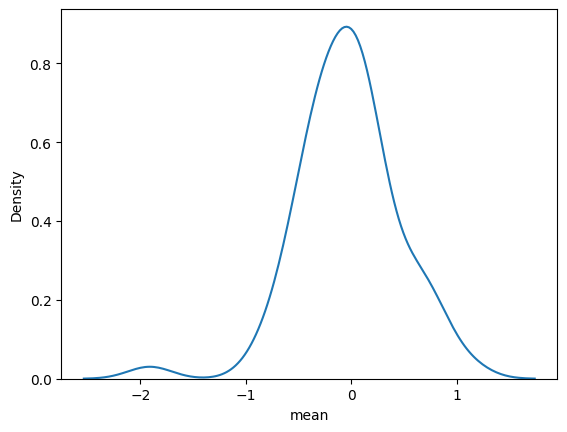

In [30]:
sns.kdeplot(df_v['mean'])

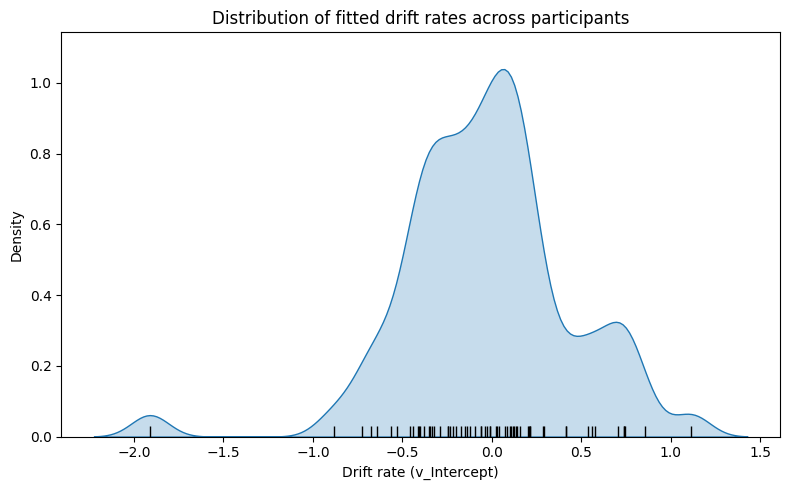

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for drift rate (v_Intercept)
df_v = df_all[df_all['param'] == 'v_Intercept']

plt.figure(figsize=(8, 5))
sns.kdeplot(df_v['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_v['mean'], color='k')
plt.xlabel("Drift rate (v_Intercept)")
plt.ylabel("Density")
plt.title("Distribution of fitted drift rates across participants")
plt.tight_layout()
plt.show()


In [36]:
all_summary = []


In [ ]:
for nsub, isub in enumerate(df_hssm['participant_id'].unique()):
    print(f"___Participant {isub}, {nsub+1}/{len(df_hssm['participant_id'].unique())}___")

    participant_folder = f"plots/Exp4/S{int(isub):04d}"   
    os.makedirs(participant_folder, exist_ok=True)

    df_hssm = df_test

    df_sub = df_hssm[df_hssm['participant_id'] == isub]
    df_sub.drop('participant_id', axis = 1, inplace=True)

    print("Median RT =", np.median(df_sub['rt']))
    print("N trials =", len(df_sub))

    model = hssm.HSSM(
        model="ddm",
        data=df_sub,
        include=[
            {
                "name":"a",
                "formula":"a ~ 1",
                "prior":{"Intercept":{"name":"Normal","mu":1.5,"sigma":0.5}}
            },
        ]
    )

    infer_data_sub = model.sample(
        cores=3,
        chains=3,
        draws=300,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
        progressbar=True,
        target_accept=0.99,
    )

    fit_dict = infer_data_sub.to_dict()

    summary_table = az.summary(infer_data_sub).reset_index().rename(columns={'index':'param'})
    summary_table['participant_id'] = isub
    all_summary.append(summary_table)

    # Save posterior plot (optional)
    az.plot_posterior(infer_data_sub)
    plt.savefig(os.path.join(participant_folder, "posterior_plot.png"))
    plt.close()

In [ ]:
df_all = pd.concat(all_summary, ignore_index=True)